In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

2025-06-27 17:05:34.649954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751043934.829419      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751043934.881554      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Sample image filenames:", os.listdir("/kaggle/input/flood-area-segmentation/Image")[:5])
print("Sample mask filenames:", os.listdir("/kaggle/input/flood-area-segmentation/Mask")[:5])

Sample image filenames: ['2008.jpg', '1075.jpg', '2029.jpg', '1031.jpg', '2021.jpg']
Sample mask filenames: ['1017.png', '2015.png', '1084.png', '2021.png', '1012.png']


In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
EPOCHS = 40

from PIL import Image

def load_images_and_masks(image_dir, mask_dir):
    images, masks = [], []
    
    image_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    mask_filenames = [f for f in os.listdir(mask_dir) if f.lower().endswith('.png')]

    mask_map = {os.path.splitext(f)[0]: f for f in mask_filenames}

    print(f"total images found: {len(image_filenames)}")
    print(f"total masks found: {len(mask_filenames)}")

    for filename in image_filenames:
        base_name = os.path.splitext(filename)[0]

        if base_name not in mask_map:
            print(f"mask not found: {base_name}")
            continue

        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, mask_map[base_name])

        try:
            image = Image.open(image_path).convert('RGB')
            image = image.resize((IMG_WIDTH, IMG_HEIGHT))
            image = np.array(image) / 255.0  #normalise
        except Exception as e:
            print(f"could not load image {image_path}: {e}")
            continue

        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"could not load mask: {mask_path}")
            continue

        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 127).astype(np.uint8)  
        mask = np.expand_dims(mask, axis=-1)  

        images.append(image)
        masks.append(mask)

    print(f"loaded {len(images)} valid image-mask pairs.")
    return np.array(images), np.array(masks)

images, masks = load_images_and_masks("/kaggle/input/flood-area-segmentation/Image", "/kaggle/input/flood-area-segmentation/Mask")

total images found: 290
total masks found: 290
loaded 290 valid image-mask pairs.


In [4]:
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (290, 128, 128, 3)
Masks shape: (290, 128, 128, 1)


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

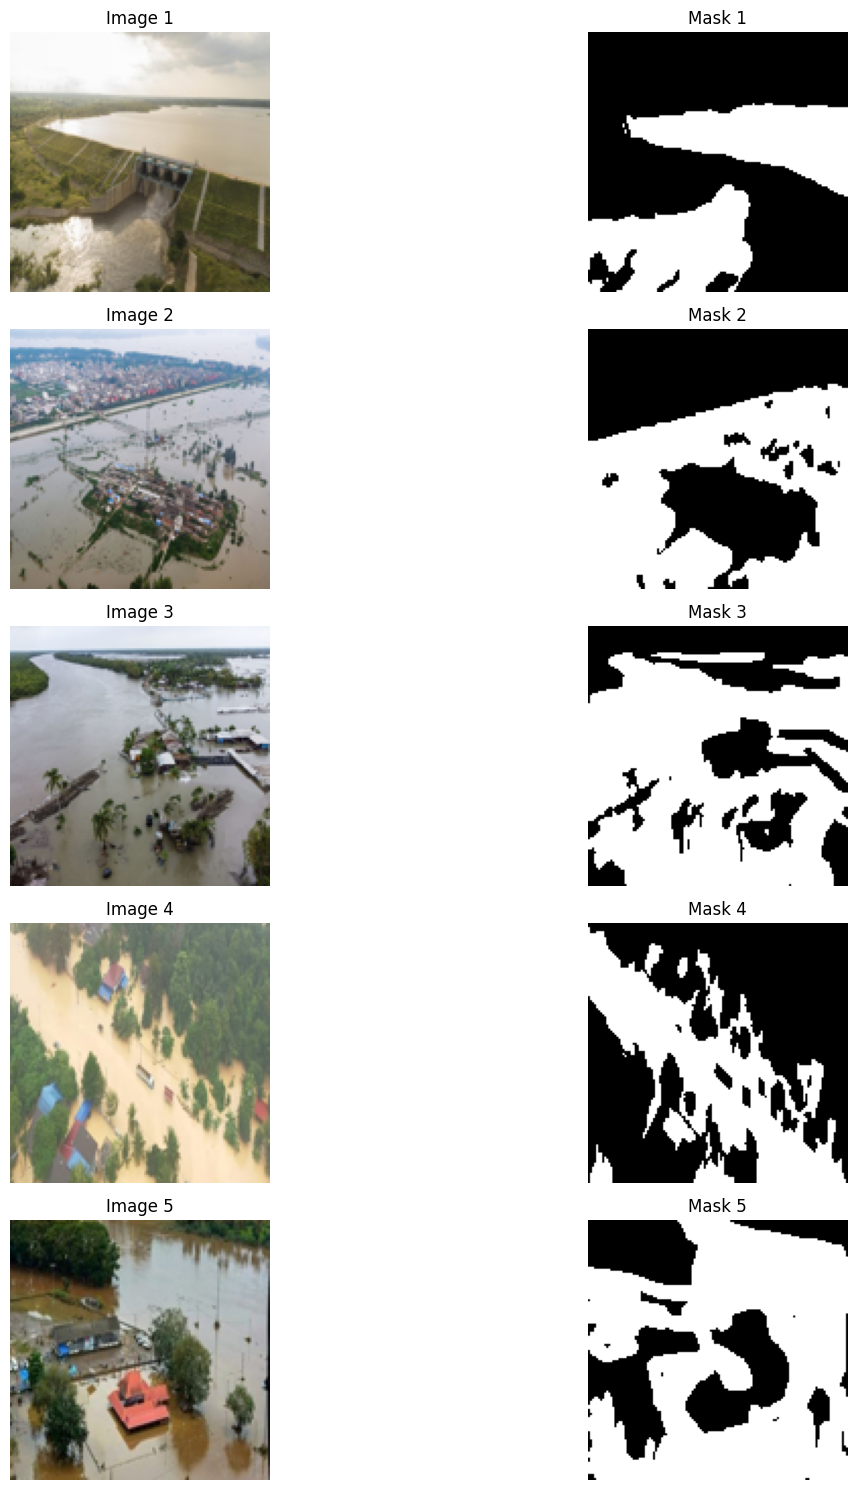

In [6]:
import matplotlib.pyplot as plt

def display_sample_images(images, masks, count=5):
    plt.figure(figsize=(15, count * 3))
    for i in range(count):
        img = images[i]
        mask = masks[i].squeeze()  # remove channel dimension

        plt.subplot(count, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(count, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(X_train, y_train, count=5)

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, images, masks, batch_size, augment=False):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        if augment:
            self.image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
            self.mask_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_x = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.masks[index * self.batch_size:(index + 1) * self.batch_size]

        if self.augment:
            seed = np.random.randint(10000)
            batch_x = next(self.image_gen.flow(batch_x, batch_size=self.batch_size, seed=seed))
            batch_y = next(self.mask_gen.flow(batch_y, batch_size=self.batch_size, seed=seed))

        return batch_x, batch_y

In [8]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    return models.Model(inputs, outputs)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1751043965.646244      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751043965.646907      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 64, 64, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
train_gen = DataGenerator(X_train, y_train, BATCH_SIZE, augment=True)
val_gen = DataGenerator(X_val, y_val, BATCH_SIZE, augment=False)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=8,             
    restore_best_weights=True  
)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        
    patience=5,        
    min_lr=1e-6        
)

In [12]:
import time
from tensorflow.keras.callbacks import Callback

class Timer(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} took {time.time() - self.start:.2f}s")

callbacks = [early_stopping, lr_reducer, Timer()]

start = time.time()
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

print(f"Total training time: {int(time.time() - start)}s")

Epoch 1/40


I0000 00:00:1751043973.711836      84 service.cc:148] XLA service 0x7b4480018760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751043973.712578      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751043973.712599      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751043974.456588      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751043997.343316      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 4/13 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.5631 - loss: 0.6984

E0000 00:00:1751044006.684073      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751044006.952918      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5783 - loss: 0.6942Epoch 1 took 68.04s
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5802 - loss: 0.6937 - val_accuracy: 0.6519 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6369 - loss: 0.6332Epoch 2 took 2.52s
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.6343 - loss: 0.6351 - val_accuracy: 0.4535 - val_loss: 0.7159 - learning_rate: 0.0010
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4707 - loss: 0.6844Epoch 3 took 2.52s
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4751 - loss: 0.6818 - val_accuracy: 0.7666 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7085 - loss: 0.5685Epoch 4 took 2.60s
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.7087 - loss: 0.5672 - val_accuracy: 0.7944 - val_loss: 0.4801 - learning_rate: 0.0010
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━

In [13]:
loss, acc = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9011 - loss: 0.2519
Validation Loss: 0.2604
Validation Accuracy: 0.8977


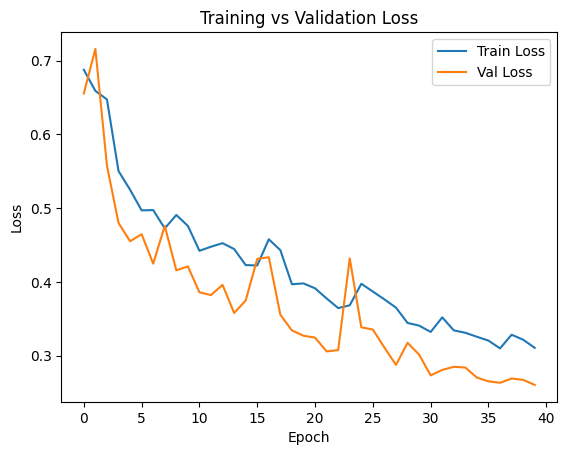

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [15]:
preds = model.predict(X_test)  

2025-06-27 17:09:11.169622: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,128,128]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-27 17:09:11.408330: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.238892802s
Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,128,128]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step


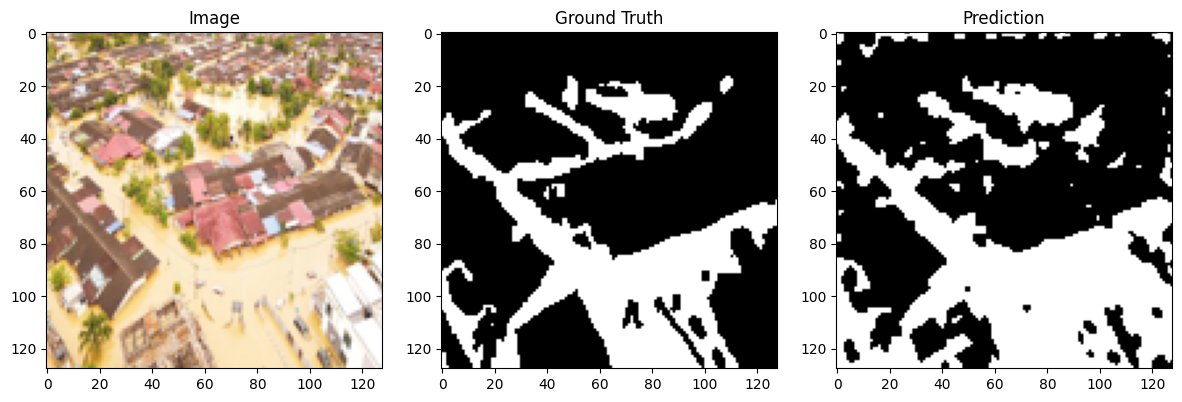

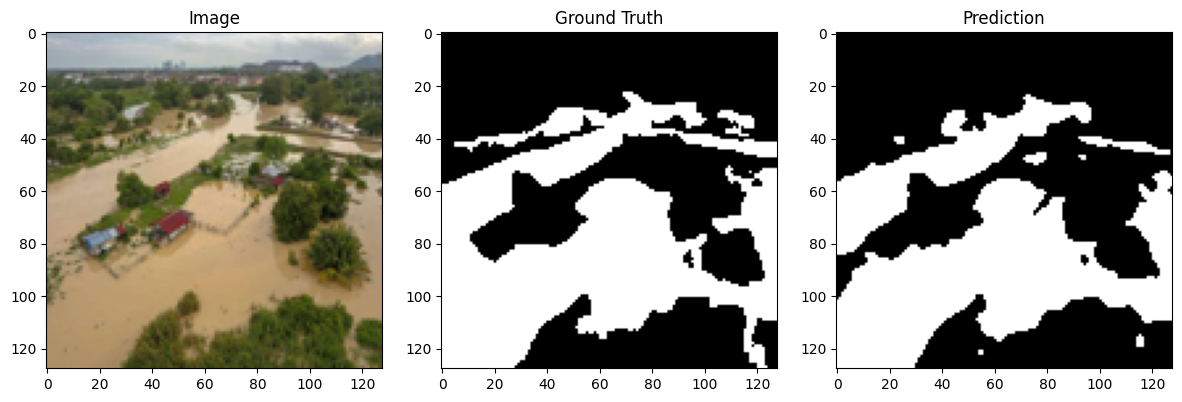

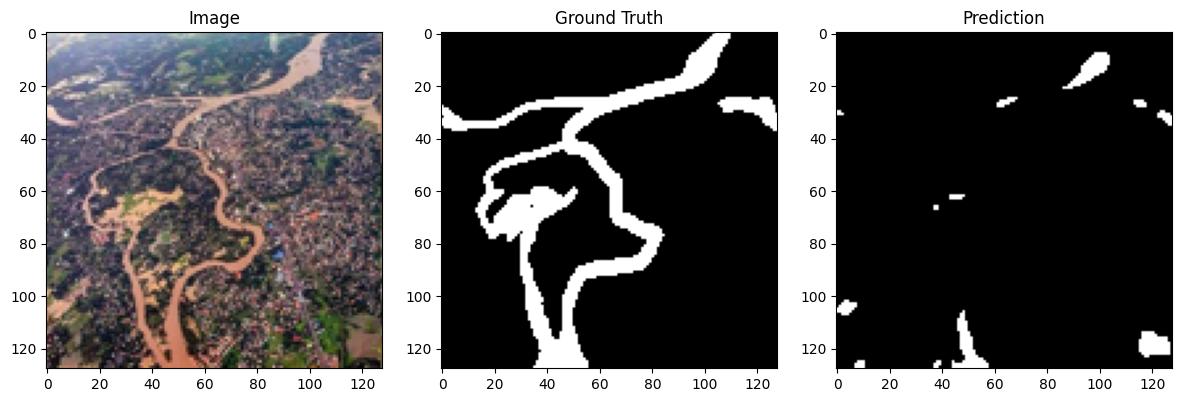

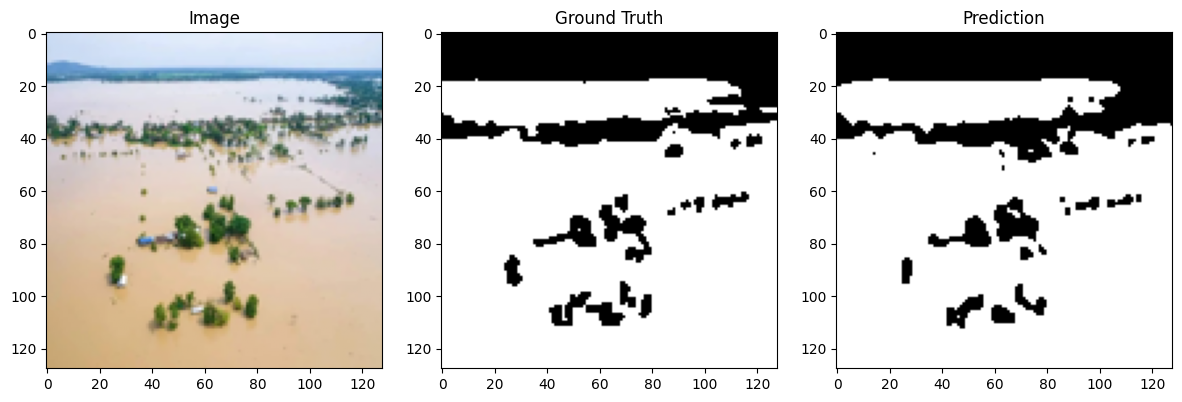

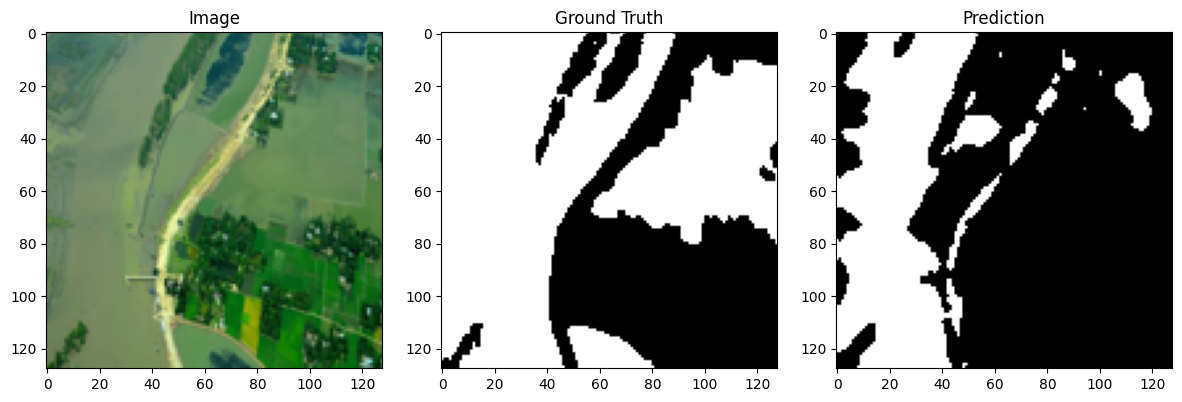

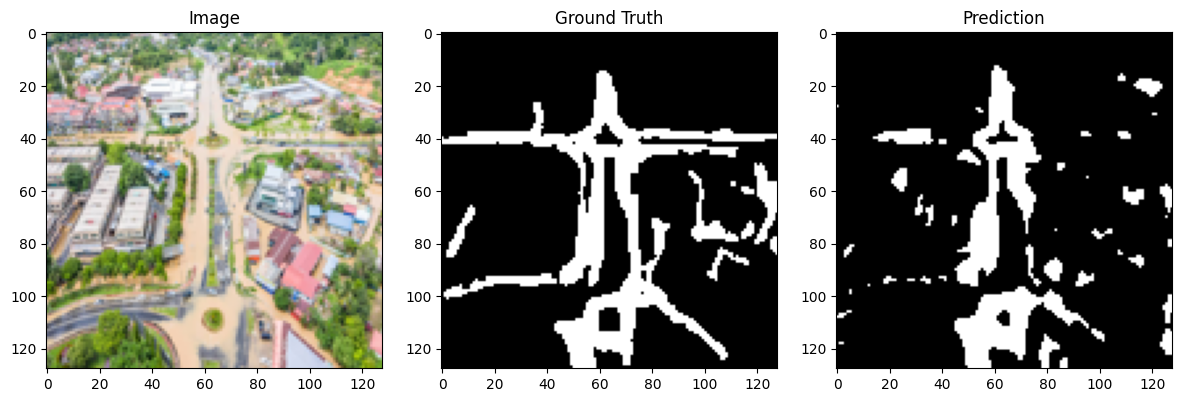

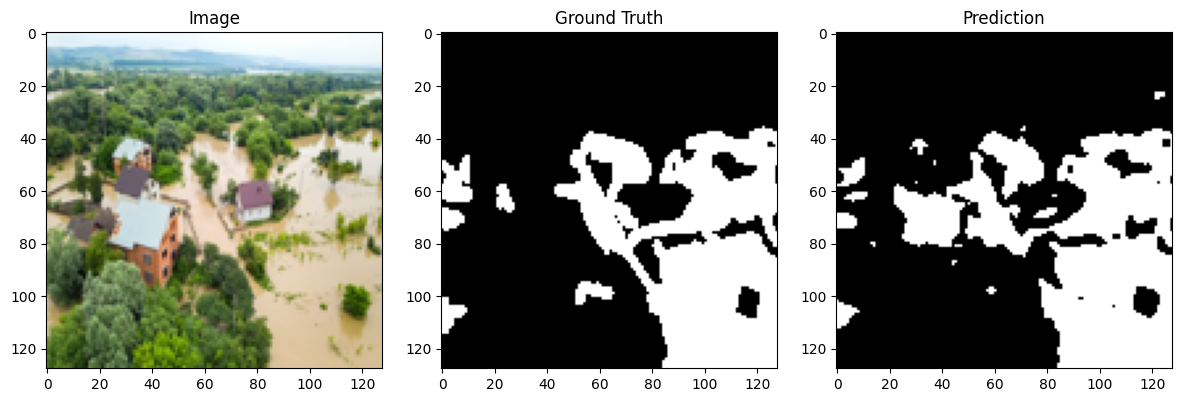

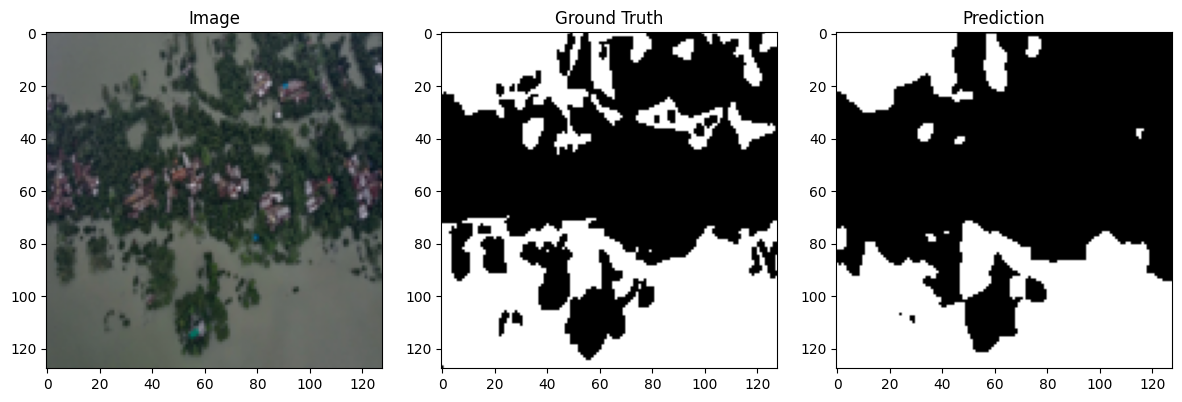

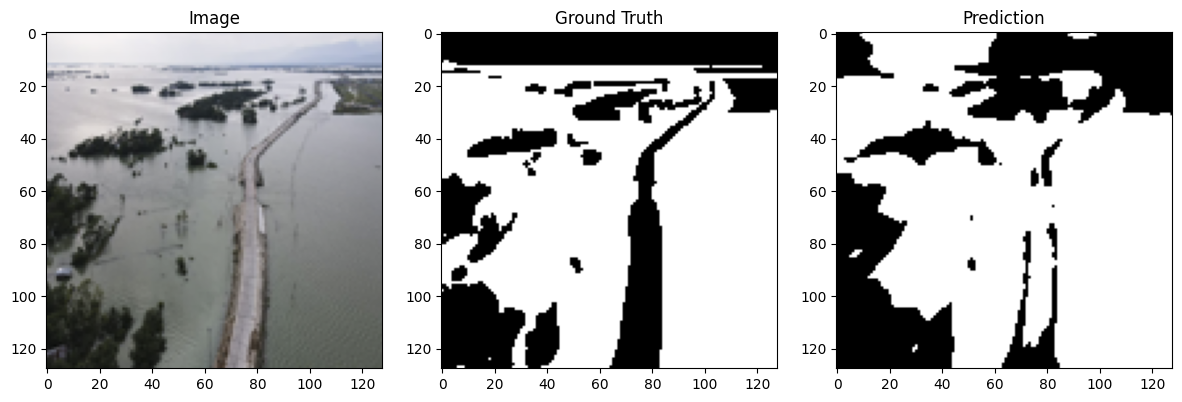

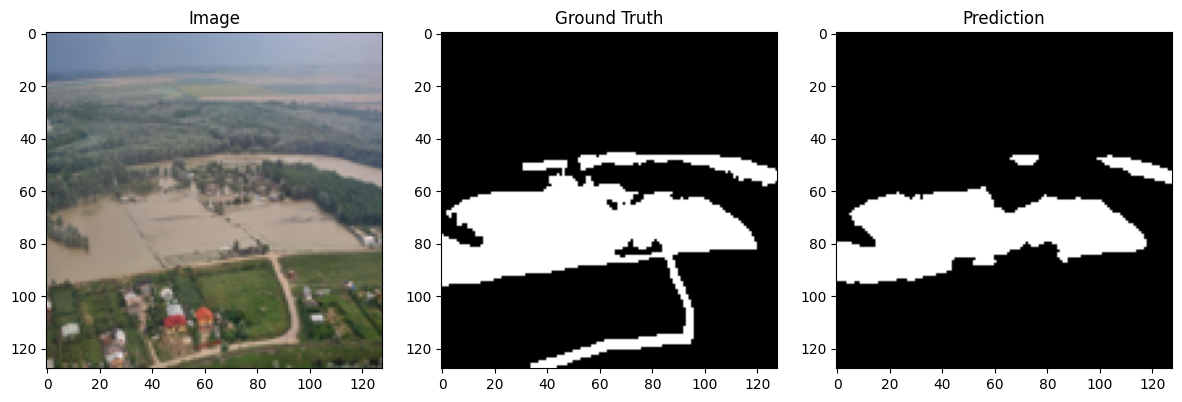

In [16]:
preds_binary = (preds > 0.5).astype(np.uint8)

for i in range(10):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds_binary[i].squeeze(), cmap='gray')
    plt.title("Prediction")

    plt.tight_layout()
    plt.show()

In [17]:
#finding Dice and IoU scores
y_true_flat = y_test.flatten()
y_pred_flat = preds_binary.flatten()

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred) - intersection
    return intersection / (union + 1e-7)

dice = dice_score(y_true_flat, y_pred_flat)
iou = iou_score(y_true_flat, y_pred_flat)

print("Dice Score:", round(dice, 4))
print("IoU Score :", round(iou, 4))

Dice Score: 0.8462
IoU Score : 0.7335


predicting on other flood images 

In [18]:
from PIL import Image
import numpy as np

def load_image(image_path, img_width=128, img_height=128):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((img_width, img_height))
        image = np.array(image) / 255.0  
        image = np.expand_dims(image, axis=0)  
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


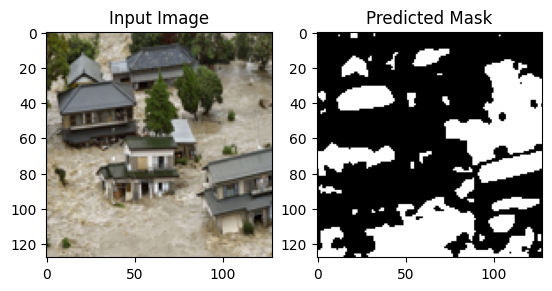

In [19]:
new_image_path = "/kaggle/input/moreimages/img1.jpg"
new_image = load_image(new_image_path, IMG_WIDTH, IMG_HEIGHT)

if new_image is not None:
    pred = model.predict(new_image)
    pred_binary = (pred > 0.5).astype(np.uint8)

    import matplotlib.pyplot as plt

    plt.subplot(1, 2, 1)
    plt.imshow(new_image.squeeze())
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


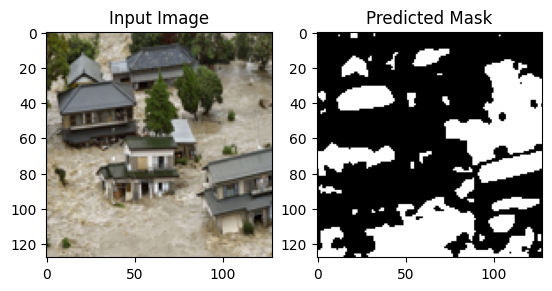

In [20]:
new_image_path = "/kaggle/input/moreimages/img1.jpg"
new_image = load_image(new_image_path, IMG_WIDTH, IMG_HEIGHT)

if new_image is not None:
    pred = model.predict(new_image)
    pred_binary = (pred > 0.5).astype(np.uint8)

    import matplotlib.pyplot as plt

    plt.subplot(1, 2, 1)
    plt.imshow(new_image.squeeze())
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


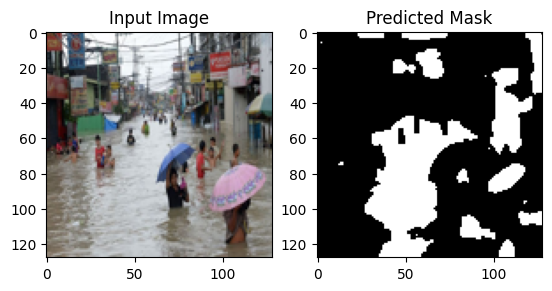

In [21]:
new_image_path = "/kaggle/input/moreimages/img2.jpg"
new_image = load_image(new_image_path, IMG_WIDTH, IMG_HEIGHT)

if new_image is not None:
    pred = model.predict(new_image)
    pred_binary = (pred > 0.5).astype(np.uint8)

    import matplotlib.pyplot as plt

    plt.subplot(1, 2, 1)
    plt.imshow(new_image.squeeze())
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

In [22]:
model.save('flood_segmentation_model.h5')